# Hourly PSDS - ROMY | FUR | TILT with FFBI

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange, append
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from andbro__store_as_pickle import __store_as_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:

## _____________________
## pressure data
# name, comp, app = "PROMY", "", ""
# name, comp, app = "FFBI", "", "_absolute"
# name, comp, app = "FFBII", "", ""

## _____________________
## ROMY data
# name, comp, app = "ROMY", "Z", ""
# name, comp, app = "ROMY", "U", ""
# name, comp, app = "ROMY", "V", ""
# name, comp, app = "ROMY", "N", ""
# name, comp, app = "ROMY", "E", ""

## _____________________
## FUR data
# name, comp, app = "FUR", "Z", ""
# name, comp, app = "FUR", "N", ""
# name, comp, app = "FUR", "E", ""

## _____________________
## TILT data
# name, comp, app = "DROMY", "N", ""
# name, comp, app = "DROMY", "E", ""


## _____________________
## coherence data
# name, comp, app = "ROMY", "Z", "_coherence"
# name, comp, app = "ROMY", "U", "_coherence"
# name, comp, app = "ROMY", "V", "_coherence"
# name, comp, app = "ROMY", "N", "_coherence"
# name, comp, app = "ROMY", "E", "_coherence"

# name, comp, app = "FUR", "Z", "_coherence"
# name, comp, app = "FUR", "N", "_coherence"
# name, comp, app = "FUR", "E", "_coherence"

# name, comp, app = "DROMY", "N", "_coherence"
# name, comp, app = "DROMY", "E", "_coherence"


year = "2023"

path = data_path+f"LNM2/PSDS/"

t1, t2 = "2023-09-23", "2023-10-22"

In [4]:
## ---------------------------------------

## load configurations
if len(comp) != 0:
    config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_{comp}_3600_config.pkl", 'rb'))
    config['filename'] = f"{name}{app}/{year}_{name}_{comp}_3600"
    config['station'] = f"{name}_{comp}"
else:
    config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_3600_config.pkl", 'rb'))
    config['filename'] = f"{name}{app}/{year}_{name}_3600"
    config['station'] = f"{name}"


config['path'] = path

config['startdate'], config['enddate'] = t1, t2



## specify paths
config['outpath_figures'] = data_path+f"LNM2/figures/"

config['path_to_outdata'] = data_path+f"LNM2/data/"

## Methods

In [5]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

## Compute PSD value per frequency band

In [6]:
d1, d2 = config['startdate'], config['enddate']

psds_medians_out, times_out = [], []

ff = pickle.load(open(config['path']+f"{config['filename']}_frequency_axis.pkl", 'rb'))

dat, dates = [], []
for jj, day in enumerate(date_range(d1, d2)):

#     if jj > 1:
#         continue

    day = str(day).split(" ")[0].replace("-", "")

    print(f"{config['filename']}_{day}_hourly.pkl")

    try:
        _dat = __load_data_file(path, f"{config['filename']}_{day}_hourly.pkl")
        # _dat, _rejected = __remove_noisy_psds(_dat, threshold_mean=1e-15, ff=ff1, flim=0.1)

    except Exception as e:
        print(e)
        print(f" -> {day}: no data found")
        continue

    for _k, _psd in enumerate(_dat):
        dat.append(_psd)
        dates.append(f"{day}_{str(_k).rjust(2, '0')}")

dat = array(dat)

ROMY_coherence/2023_ROMY_E_3600_20230923_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20230924_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20230925_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20230926_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20230927_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20230928_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20230929_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20230930_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20231001_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20231002_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20231003_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20231004_hourly.pkl
ROMY_coherence/2023_ROMY_E_3600_20231005_hourly.pkl
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY_coherence/2023_ROMY_E_3600_20231005_hourly.pkl'
 -> 20231005: no data found
ROMY_coherence/2023_ROMY_E_3600_20231006_hourly.pkl
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY_coherence/2023_ROMY_E_3600_20231006_hourly.pkl'


### Get frequency bands

In [7]:
def __get_octave_bands(fmin, fmax, fband_type="octave", plot=False):

    """
    Computing octave / one-third-octave bands

    Arguments:
        - fmin:    (float) minimum center frequency
        - fmax:    (float) maximum center frequency
        - fband_type:    [octave] / one-third-octave
        - plot:    (bool) show frequency bands

    Example:

    >>> flower, fupper, fcenter = __get_octave_bands(f_min, f_max, fband_type="octave", plot=False)

    """

    import matplotlib.pyplot as plt
    from numpy import sqrt, array
    from acoustics import bands

    f_lower, f_upper, f_centers = [], [], []

    if fband_type == "octave":
        f_centers = bands.octave(fmin, fmax)
        f_lower = bands.octave_low(fmin, fmax)
        f_upper = bands.octave_high(fmin, fmax)

    if fband_type == "one-third-octave":
        f_centers = bands.third(fmin, fmax)
        f_lower = bands.third_low(fmin, fmax)
        f_upper = bands.third_high(fmin, fmax)

    if plot:
        plt.figure()
        for fl, fc, fu in zip(f_lower, f_centers, f_upper):
            plt.axvline(fu, color="r")
            plt.axvline(fl, color="r")
            plt.axvline(fc)
            plt.axvline(fmin, color="g")
            plt.axvline(fmax, color="g")
            plt.xscale("log")
        plt.show()

    return array(f_lower), array(f_upper), array(f_centers)

In [8]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

### Get PSD average for frequency bands

In [9]:
def __get_band_average(freq, data, f_center, f_upper, f_lower):

    ## get frequency indices
    fl_idx, fu_idx = [], []

    for _k, (fl, fu) in enumerate(zip(f_lower, f_upper)):
        if _k <= len(f_center):

            for _i, _f in enumerate(freq):
                if _f >= fl:
                    fl_idx.append(int(_i))
                    break

            for _i, _f in enumerate(freq):
                if _f >= fu:
                    fu_idx.append(int(_i))
                    break

    ## compute average per band
    psd_avg, fc, fu, fl = [], [], [], []
    for _n, (ifl, ifu) in enumerate(zip(fl_idx, fu_idx)):

        avg = []
        for _psd in data:
            avg.append(median(_psd[ifl:ifu]))
        psd_avg.append(array(avg))
        fc.append(f_center[_n])
        fu.append(f_upper[_n])
        fl.append(f_lower[_n])

    psd_avg = array(psd_avg)


    ## check up plot
    plt.figure(figsize=(15, 5))

    for _j, dd in enumerate(psd_avg):
        plt.scatter(ones(len(dd))*fc[_j], dd, s=5)
        plt.xscale("log")
        plt.yscale("log")

    plt.show();


    ## output
    out = {}
    out['psd_avg'] = psd_avg
    out['fcenter'] = array(fc)
    out['fupper'] = array(fu)
    out['flower'] = array(fl)
    out['dates'] = dates

    return out

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


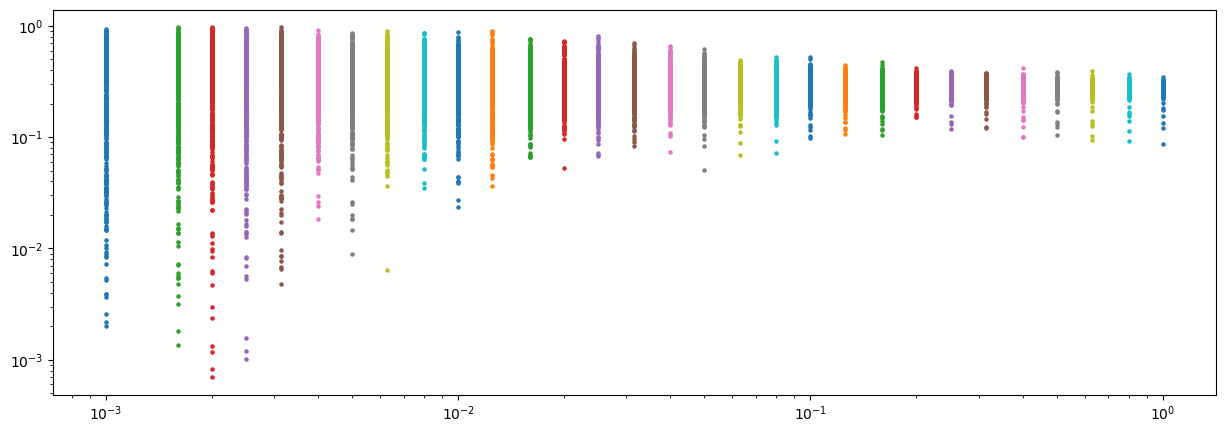

In [10]:
out0 = __get_band_average(ff, dat, f_center, f_upper, f_lower)

## Store data

In [11]:
# __store_as_pickle(out0, config['path_to_outdata']+config['station']+".pkl")

In [12]:
## create and fill data frame
df_out = DataFrame()

df_out['dates'] = out0['dates']

for _i, fc in enumerate(out0['fcenter']):
    df_out[round(fc, 5)] = out0['psd_avg'][_i]

## store as pickle file
df_out.to_pickle(config['path_to_outdata']+config['station']+app+".pkl")

## Plot Density Histogram

In [13]:
from functions.get_hist_loglog import __get_hist_loglog

In [14]:
# out = __get_hist_loglog(dat, ff, bins=100, density=False, axis=1, plot=True)